In [9]:
#Load packages and functions

import numpy as np
import astropy.io.fits as fits
import glob
import matplotlib.pyplot as plt
import astropy
from astropy import modeling
from scipy.signal import argrelextrema
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit

#Plot stuff
from bokeh.io import output_notebook, show
from bokeh.models import Title, HoverTool, Span
from bokeh.plotting import figure
from bokeh.layouts import gridplot
output_notebook()

#wavelength, flux
def wf(dat): #whichord,dat. Setup:   w,f=wf(#,dat)
    w=np.array([d[0] for d in dat])
    f=np.array([d[1] for d in dat])
    return w,f

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar=''): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    if len(params)==1:
        varrs=varrs[0]
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')

Loading BokehJS ...

# Normalization Function

In [14]:
#operate on unnorm w,f. Return w, normalized f.
#operate on unnorm w,f. Return w, normalized f.
def norm(w,f,pltt='y'):
    #roughly skip the dips
    #dodge broad Ha:
    favg=np.median(f) #Try median, hopefully not ALL peak
    print('favg:',favg)
    Hapeak=[i for i in range(len(w)) if f[i]>favg*3]
    print(Hapeak)
    if len(Hapeak)>0: #peak present
        Hali=np.min(Hapeak) #left index
        Hari=np.max(Hapeak) #right index
        Hawid=w[Hari]-w[Hali] #wavelength "width" of Ha
        pad=int(Hawid/1.) #pad each side
        HaL,HaR=w[Hali]-pad,w[Hari]+pad #Ha left, right
    else: #peak low or not present, guess
        HaL=6555
        HaR=6570
    print('Ha range:',HaL,'-',HaR)
    wc=[w[i] for i in range(len(w)) if (w[i]<6155) or (w[i]>6175 and w[i]<6489) or (w[i]>6506 and w[i]<6555) or (w[i]>6506 and w[i]<HaL) or (w[i]>HaR)]
    fc=[f[i] for i in range(len(w)) if (w[i]<6155) or (w[i]>6175 and w[i]<6489) or (w[i]>6506 and w[i]<6555) or (w[i]>6506 and w[i]<HaL) or (w[i]>HaR)]

    fstd=np.std(fc)/3.
    print('flux std:',fstd)
    #drop anything > fstd from previous average.
    di=40
    fcc=[fc[i] for i in np.array(range(len(fc)-2*di))+di if abs(fc[i]-np.median(fc[i-di:i+di]))<fstd]
    wcc=[wc[i] for i in np.array(range(len(fc)-2*di))+di if abs(fc[i]-np.median(fc[i-di:i+di]))<fstd]

    if pltt=='y':
        plt.figure()
        plt.plot(w,f)
        plt.plot(wcc,fcc)

    ffitz,a,b,c,d=np.polyfit(wcc,fcc,3,full=True)
    print('residuals:',a[0])
    x=np.arange(w[0],w[-1],(w[-1]-w[0])/len(w))
    ffit=np.poly1d(ffitz)
    if pltt=='y':
        plt.plot(x,ffit(x))

        plt.plot([HaL,HaL],[400,600],c='red')
        plt.plot([HaR,HaR],[400,600],c='lime')
        guess=6155
        plt.plot([guess,guess],[400,600],c='red')
        guess=6175
        plt.plot([guess,guess],[400,600],c='lime')
        guess=6489
        plt.plot([guess,guess],[400,600],c='red')
        guess=6506
        plt.plot([guess,guess],[400,600],c='lime')
        plt.ylim(favg*0.5,favg*2)

        plt.figure(figsize=(12,4))
        fn=f/ffit(w)
        plt.plot(w,fn)
        plt.xlabel('Wavelength (A)')
        plt.ylabel('Normalized Flux')
        plt.ylim(0.5,2)
        
    return fn

#fancy plotspec
def plotspec(w,fn):
    bfig = figure(width=990,height=330,#y_range=(0.,1.25),
                      tools=['xwheel_zoom','ywheel_zoom','xpan','ypan','reset'],active_scroll='xwheel_zoom')
    bfig.line(w,fn)
    bfig.add_tools(HoverTool(tooltips=[('Intensity','@y'),('Wavelength', '@x')],mode='vline'))
    #bfig.add_layout(Title(text='{} - {}'.format(scihdu[0].header['OBJECT'],fitsfile_fp), align='left'),'above')
    bfig.xaxis.axis_label = 'Wavelength (A)'
    bfig.yaxis.axis_label = 'Normalized Flux'
    bfig.axis.major_tick_out = 0
    bfig.axis.major_tick_in = 10
    bfig.axis.minor_tick_in = 5
    bfig.axis.minor_tick_out = 0
    show(bfig)

# Procedure

Open wavelength-calibrated unnormalized spectrum (wfun file).

Use norm() on unnormalized flux. Returns normalized flux!

Save w,normalized flux to a new file (wf, or just wf). This data is now fully reduced, extracted, wavelength-calibrated, and normalized, and ready for scientific analysis!

['#w', 'f']


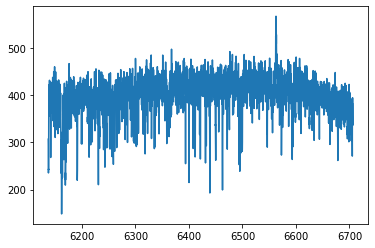

In [11]:
#open wavelength-calibrated unnormalized file:
file='CG4_8_unnorm.dat'
w,f=opendat('',file,['#w','f'])

#Take a look.
plt.figure()
plt.plot(w,f)

favg: 402.54632762324286
[]
Ha range: 6555 - 6570
flux std: 12.856647394441053
residuals: 120633.3413020439


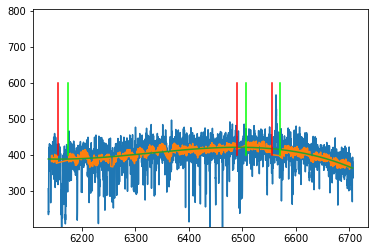

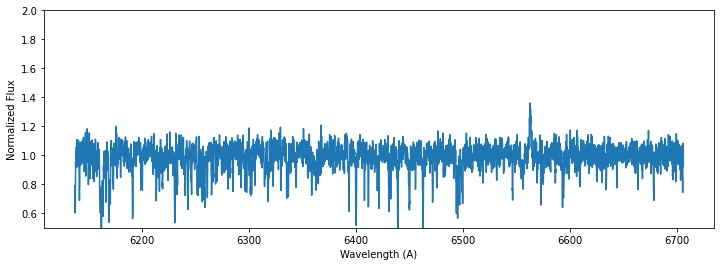

In [12]:
# Normalize the flux. Take a look. Save.
fn=norm(w,f)

In [15]:
#final check.
plotspec(w,fn)

Like it? save it as .fits, like you did for wfun, but now it's wfn? For normalized? Or just omit extra letters at this point...?